In [ ]:
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

PROJECT_ROOT = r"C:\University\4course\CV_Project"
os.chdir(PROJECT_ROOT)
print("CWD:", os.getcwd())

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from config import DEVICE
from models.autoencoder import ConvAutoencoder

print("Using device:", DEVICE)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CWD: C:\University\4course\CV_Project
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [ ]:
# DataLoaders для AE (через get_dataloaders)

from utils.dataset import get_dataloaders
from torchvision import transforms
from torch.utils.data import DataLoader

IMG_SIZE = 128
BATCH_SIZE = 64

# Спочатку просто отримуємо train/val через ТВОЮ ж утиліту
clf_train_loader, clf_val_loader, class_names = get_dataloaders(
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,      # не критично, але логічно
    aug_type="baseline",    # будь-який, ми зараз все одно перезапишемо трансформи
)

print("Класи:", class_names)
print("Train size:", len(clf_train_loader.dataset))
print("Val size:", len(clf_val_loader.dataset))

# Тепер створюємо окремі трансформації для AUTOENCODER-а
ae_train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),        # залишаємо [0,1], без Normalize
])

ae_val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Беремо ті самі датасети, але міняємо в них transform
train_ds = clf_train_loader.dataset
val_ds   = clf_val_loader.dataset

train_ds.transform = ae_train_transform
val_ds.transform   = ae_val_transform

# Створюємо DataLoader-и для AE (можна використати ті ж, але так прозоріше)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

len(train_ds), len(val_ds), class_names


Класи: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034
Val size: 3000


(14034, 3000, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [ ]:
# тренувальна функція для AE (MSE + early stopping)

def train_autoencoder(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    lr=1e-3,
    patience=5,
    ckpt_path="checkpoints/autoencoder_best.pth",
):
    os.makedirs("checkpoints", exist_ok=True)

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
    }

    best_val_loss = float("inf")
    best_state = None
    no_improve_epochs = 0

    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_train_loss = 0.0
        n_train = 0

        for x, _ in train_loader:
            x = x.to(device)

            optimizer.zero_grad()
            x_recon, _ = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x.size(0)
            n_train += x.size(0)

        train_loss = running_train_loss / n_train

        # --- validation ---
        model.eval()
        running_val_loss = 0.0
        n_val = 0

        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_recon, _ = model(x)
                loss = criterion(x_recon, x)
                running_val_loss += loss.item() * x.size(0)
                n_val += x.size(0)

        val_loss = running_val_loss / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"train_loss={train_loss:.4f} "
            f"val_loss={val_loss:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

    total_time_min = (time.time() - start_time) / 60.0
    print(f"Training finished in {total_time_min:.2f} min, best val_loss={best_val_loss:.4f}")

    if best_state is not None:
        torch.save(best_state, ckpt_path)
        print("Saved best autoencoder to:", ckpt_path)

    return history, best_val_loss


In [ ]:
# створюємо й тренуємо автоенкодер

model = ConvAutoencoder(latent_dim=128).to(DEVICE)
history, best_val_loss = train_autoencoder(
    model,
    train_loader,
    val_loader,
    DEVICE,
    num_epochs=20,
    lr=1e-3,
    patience=5,
    ckpt_path="checkpoints/autoencoder_best.pth",
)


Epoch [1/20] train_loss=0.0331 val_loss=0.0207
Epoch [2/20] train_loss=0.0179 val_loss=0.0160
Epoch [3/20] train_loss=0.0152 val_loss=0.0143
Epoch [4/20] train_loss=0.0138 val_loss=0.0134
Epoch [5/20] train_loss=0.0130 val_loss=0.0129
Epoch [6/20] train_loss=0.0125 val_loss=0.0123
Epoch [7/20] train_loss=0.0120 val_loss=0.0120
Epoch [8/20] train_loss=0.0118 val_loss=0.0117
Epoch [9/20] train_loss=0.0115 val_loss=0.0117
Epoch [10/20] train_loss=0.0115 val_loss=0.0116
Epoch [11/20] train_loss=0.0113 val_loss=0.0116
Epoch [12/20] train_loss=0.0112 val_loss=0.0116
Epoch [13/20] train_loss=0.0111 val_loss=0.0118
Epoch [14/20] train_loss=0.0110 val_loss=0.0116
Epoch [15/20] train_loss=0.0109 val_loss=0.0116
Early stopping triggered.
Training finished in 5.82 min, best val_loss=0.0116
Saved best autoencoder to: checkpoints/autoencoder_best.pth


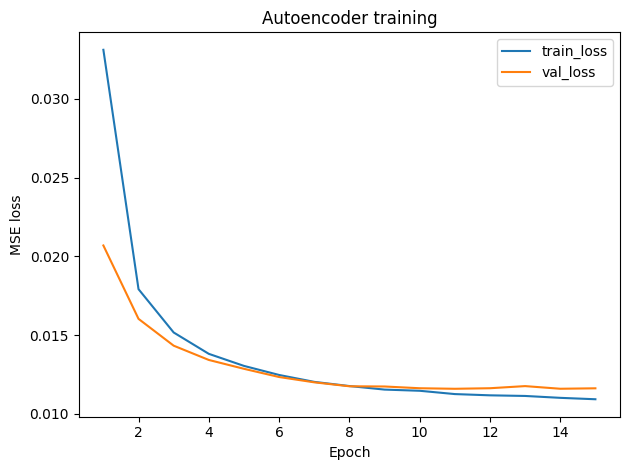

In [ ]:
# графік train/val loss

epochs = range(1, len(history["train_loss"]) + 1)
plt.figure()
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Autoencoder training")
plt.tight_layout()
plt.show()


**ЗАСТОСУВАННЯ ДЕТЕКЦІЇ АНОМАЛІЙ**

In [ ]:
# завантаження найкращої моделі та підрахунок reconstruction error

best_ae = ConvAutoencoder(latent_dim=128).to(DEVICE)
state_dict = torch.load("checkpoints/autoencoder_best.pth", map_location=DEVICE)
best_ae.load_state_dict(state_dict)
best_ae.eval()

import torch.nn.functional as F

recon_errors = []
val_images = []  # для візуалізації
val_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        x_recon, _ = best_ae(x)
        # MSE per image
        mse_per_img = F.mse_loss(x_recon, x, reduction="none")
        mse_per_img = mse_per_img.view(x.size(0), -1).mean(dim=1)  # [batch]

        recon_errors.extend(mse_per_img.cpu().tolist())
        val_images.append(x.cpu())
        val_labels.extend(y.tolist())

recon_errors = np.array(recon_errors)
val_images = torch.cat(val_images, dim=0)  # [N, 3, H, W]
len(recon_errors), val_images.shape


(3000, torch.Size([3000, 3, 128, 128]))

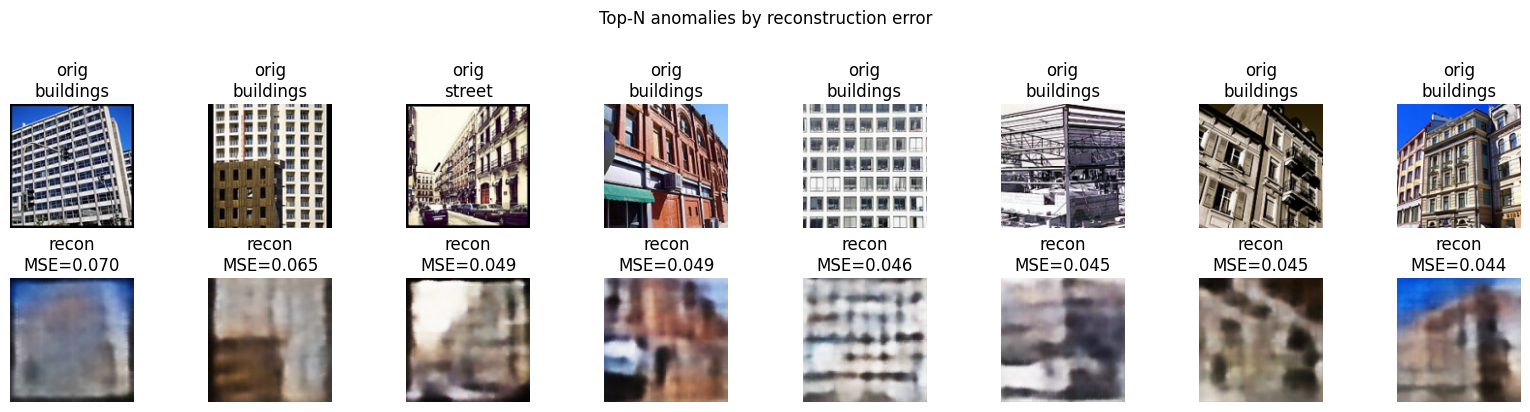

In [ ]:
# топ-аномалії (найбільший reconstruction error)

N = 8  # скільки показати
top_idx = np.argsort(-recon_errors)[:N]  # сортуємо за спаданням

fig, axes = plt.subplots(2, N, figsize=(2*N, 4))

for i, idx in enumerate(top_idx):
    img = val_images[idx]
    label = class_names[val_labels[idx]]

    # оригінал
    axes[0, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[0, i].set_title(f"orig\n{label}")
    axes[0, i].axis("off")

    # реконструкція
    with torch.no_grad():
        x_in = img.unsqueeze(0).to(DEVICE)
        x_rec, _ = best_ae(x_in)
    rec = x_rec.squeeze(0).cpu()

    axes[1, i].imshow(np.transpose(rec.numpy(), (1, 2, 0)))
    axes[1, i].set_title(f"recon\nMSE={recon_errors[idx]:.3f}")
    axes[1, i].axis("off")

plt.suptitle("Top-N anomalies by reconstruction error", y=1.02)
plt.tight_layout()
plt.show()


**ЗМЕНШЕННЯ РОЗМІРНОСТІ + ВІЗУАЛІЗАЦІЯ ЛАТЕНТНОГО ПРОСТОРУ**

In [ ]:
# збираємо латентні вектори для частини вибірки

latents = []
labels_subset = []

max_samples = 2000  # щоб t-SNE не вмер
count = 0

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        _, z = best_ae(x)  # z: [batch, latent_dim]
        latents.append(z.cpu())
        labels_subset.extend(y.tolist())
        count += x.size(0)
        if count >= max_samples:
            break

latents = torch.cat(latents, dim=0).numpy()
labels_subset = np.array(labels_subset)[: latents.shape[0]]

latents.shape, labels_subset.shape


((2048, 128), (2048,))

C:\Users\User\AppData\Local\Temp\ipykernel_13868\2623710185.py:21: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 6
  plt.legend(


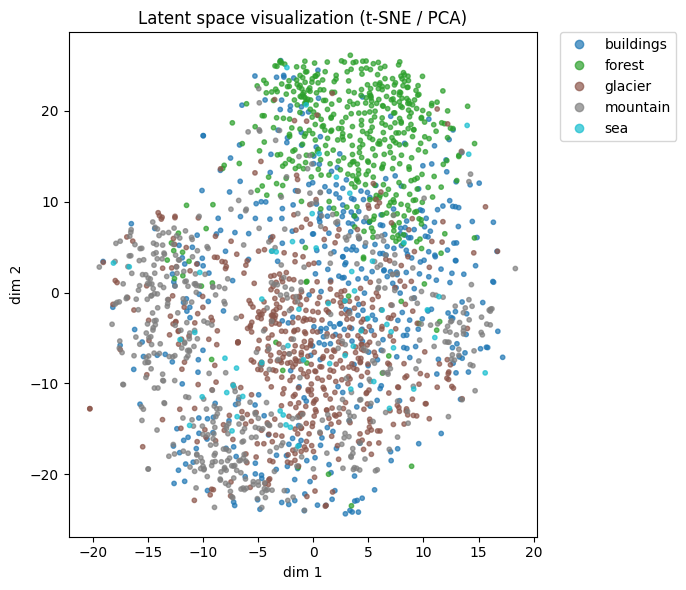

In [ ]:
# t-SNE (або PCA) та візуалізація

use_tsne = True

if use_tsne:
    reducer = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30)
else:
    reducer = PCA(n_components=2)

latents_2d = reducer.fit_transform(latents)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    latents_2d[:, 0],
    latents_2d[:, 1],
    c=labels_subset,
    cmap="tab10",
    alpha=0.7,
    s=10,
)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=class_names,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
)
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.title("Latent space visualization (t-SNE / PCA)")
plt.tight_layout()
plt.show()


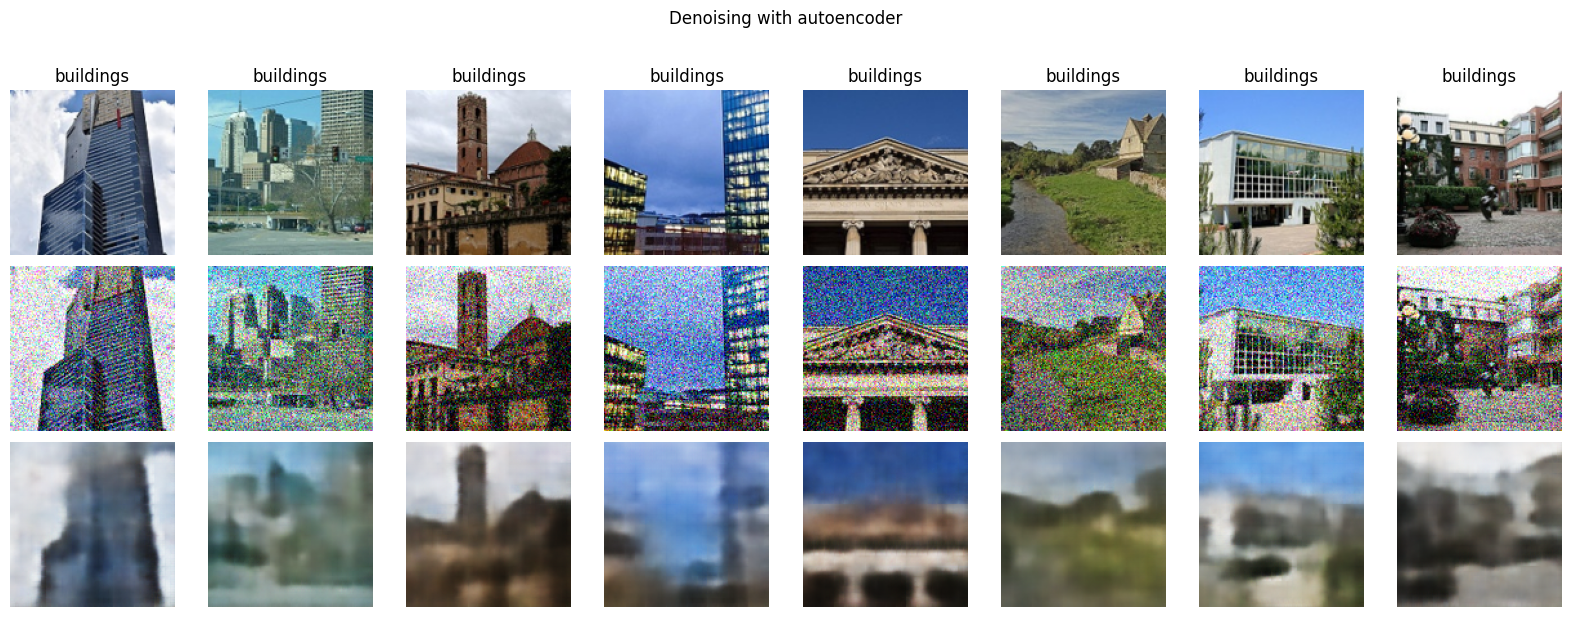

In [ ]:
# приклад денойзингу

def add_noise(x, sigma=0.2):
    noise = torch.randn_like(x) * sigma
    noisy = x + noise
    return torch.clamp(noisy, 0.0, 1.0)

# беремо один batch з val_loader
x_batch, y_batch = next(iter(val_loader))
x_batch = x_batch[:8]  # 8 зображень
y_batch = y_batch[:8]
x_batch = x_batch.to(DEVICE)

x_noisy = add_noise(x_batch, sigma=0.2)
with torch.no_grad():
    x_denoised, _ = best_ae(x_noisy)

x_batch = x_batch.cpu()
x_noisy = x_noisy.cpu()
x_denoised = x_denoised.cpu()

fig, axes = plt.subplots(3, 8, figsize=(2*8, 6))

for i in range(8):
    orig = x_batch[i]
    noisy = x_noisy[i]
    den = x_denoised[i]

    axes[0, i].imshow(np.transpose(orig.numpy(), (1, 2, 0)))
    axes[0, i].axis("off")
    axes[0, i].set_title(class_names[y_batch[i]])

    axes[1, i].imshow(np.transpose(noisy.numpy(), (1, 2, 0)))
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_ylabel("noisy", rotation=0, labelpad=35)

    axes[2, i].imshow(np.transpose(den.numpy(), (1, 2, 0)))
    axes[2, i].axis("off")
    if i == 0:
        axes[2, i].set_ylabel("denoised", rotation=0, labelpad=35)

plt.suptitle("Denoising with autoencoder", y=1.02)
plt.tight_layout()
plt.show()
